In [65]:
%matplotlib inline
import numpy as np
import math
import matplotlib.pyplot as plt

class Landmark:
    def __init__(self,x,y):
        self.position = np.array([x,y])
        
    def __str__(self):
        return "(%f,%f)" % (self.position[0],self.position[1]) 
    
    def getX(self):
        return self.position[0]
    
    def getY(self):
        return self.position[1]
    

In [66]:
actual_landmarks = (Landmark(0,0),Landmark(1,0),Landmark(0.5,0.5))

In [67]:
xs = [e.getX() for e in actual_landmarks]
ys = [e.getY() for e in actual_landmarks]

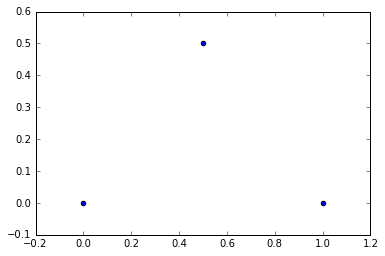

In [68]:
plt.scatter(xs,ys)

In [89]:
class Robot:
    def __init__(self,x,y,rad):
        self.poses = [np.array([x,y,rad])]
        
    def getX(self):             return self.poses[-1][0]
    def getY(self):             return self.poses[-1][1]
    def getTheta(self):     return self.poses[-1][2]
    def getXs(self):        return [e[0] for e in self.poses]
    def getYs(self):        return [e[1] for e in self.poses]
    def getThetas(self):        return [e[2] for e in self.poses]
    
    def move(self,fw,rot):
        x = self.getX() + fw * math.cos(self.getTheta())
        y = self.getY() + fw * math.sin(self.getTheta()) 
        rad = self.getTheta() + rot
        self.poses.append(np.array([x,y,rad]))

In [90]:
robot = Robot(0,0,0)

for i in range(5):
    robot.move(0.2,3.14/6)

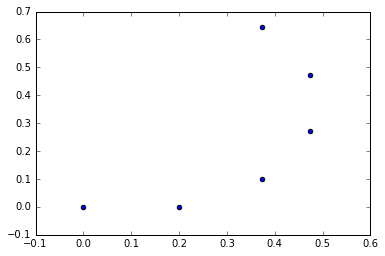

In [93]:
rxs = robot.getXs()
rys = robot.getYs()
plt.scatter(rxs,rys)